In [1]:
# Used modules
import re
import time
import warnings
import pandas as pd
import numpy as np
import tldextract as tlx
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse

plt.style.use('classic')
%matplotlib inline

sns.set()

# Loading the dataset

In [2]:
initial_dataset =  pd.read_csv('../data/data_21K_good_and_malicious_URLs.csv')
initial_dataset.head()

url  label
0  startbuyingstocks.com/      0
1              qqcvk.com/      0
2      432parkavenue.com/      0
3         gamefoliant.ru/      0
4                orka.cn/      0

In [3]:
def print_df_shape(df):
    rows = df.shape[0]
    cols = df.shape[1]
    print (str(rows) + '\trows')
    print (str(cols) + '\tcolumns')

In [4]:
def remove_duplicates(dataset):
    dataset.dropna(inplace=True)
    dataset.drop_duplicates(inplace=True)
    dataset.reset_index(drop=True)

In [5]:
print ('Before removing duplicates:')
print_df_shape(initial_dataset)
old_number_of_rows = initial_dataset.shape[0]

remove_duplicates(initial_dataset)

print ('\nAfter removing duplicates:')
print_df_shape(initial_dataset)
new_number_of_rows=initial_dataset.shape[0]

print ("\n" + str(old_number_of_rows - new_number_of_rows) + ' rows were removed')

Before removing duplicates:
20905	rows
2	columns

After removing duplicates:
20875	rows
2	columns

30 rows were removed


In [6]:
red_color = "#f45f41"
green_color = "#42f492"
sns.set(style="white")
def count_plot(dataset, x, figsize=(15, 8), xlim=(None, None)):
    fig = plt.figure(figsize=figsize)
    cp = sns.countplot(
        data=dataset, 
        x=x, 
        hue="label", 
        palette={1: red_color, 0: green_color}
    ).set(xlim=xlim)

Malicious URLs:	16028
Benign URLs:	4847


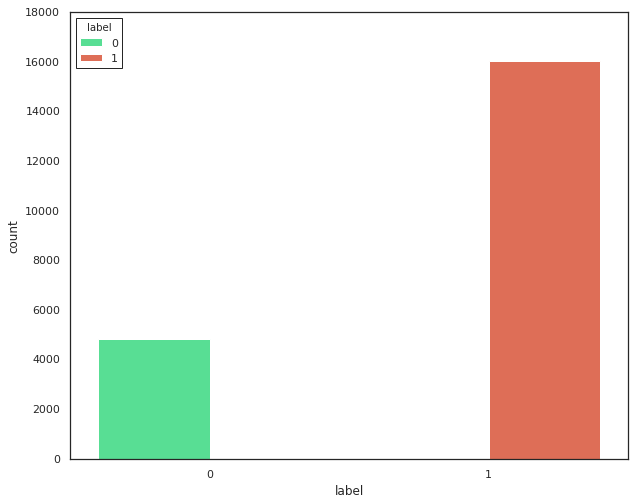

In [7]:
count_plot(initial_dataset, "label", (10,8))
print ("Malicious URLs:\t{}".format(initial_dataset['label'][initial_dataset.label == 1].count()))
print ("Benign URLs:\t{}".format(initial_dataset['label'][initial_dataset.label == 0].count()))

# Feature Engineering

In [8]:
# Method to count number of delimiters
def count_delimiters(url):
    count = 0
    delimiters = [';', '_', '?', '=', '&']
    for character in url:
        if character in delimiters:
            count += 1
    return count

In [9]:
def count_query_parameters(query):
    if not query:
        return 0
    else:
        return len(query.split('&'))

In [10]:
def compute_features(url):
    dbl_slash = url.count('//')
    extracted_tld = tlx.extract(url)
    parsed_url = urlparse(url)
    return dict({
        "hyphens": url.count('-'),
        "ats": url.count('@'),
        "dblbackslash": url.count('\\'),
        "fwdslash": url.count('/'),
        "dots": url.count('.'),
        "subdomaindots": extracted_tld.subdomain.count('.'),
        "urllength": len(url),
        "pathlength": len(parsed_url.path),
        "subdomainlength": len(extracted_tld.subdomain),
        "domainlength": len(extracted_tld.domain),
        "delimiters": count_delimiters(url),
        "parameters": count_query_parameters(parsed_url.query),
        "protocol": 1 if parsed_url.scheme == 'https' else 0,
        "dblfwdslash": dbl_slash if dbl_slash > 1 else 0,
        "ip": 1 if re.match(r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$",parsed_url.netloc) else 0
        
    })

In [11]:
def add_features(dataset, features):
    columns = features.copy()
    columns['url'] = []
    columns['label'] = []
    for i in range(len(dataset)):
        columns['url'].append(dataset['url'].iloc[i])
        columns['label'].append(dataset['label'].iloc[i])
        computed_features = compute_features(str(dataset['url'].iloc[i]))
        for column in columns.keys():
            if column not in ['url', 'label']:
                columns[column].append(computed_features[column])
    return columns

In [12]:
data = {
    "hyphens": [],
    "ats": [],
    "dblbackslash": [],
    "fwdslash": [],
    "dblfwdslash": [],
    "subdomainlength": [],
    "domainlength": [],
    "delimiters": [],
    "dots": [],
    "subdomaindots": [],
    "parameters": [],
    "protocol": [],
    "urllength": [],
    "pathlength": [],
    "ip": []
}
dtf = add_features(initial_dataset, data)
print_df_shape(initial_dataset)
dataset = pd.DataFrame(data=dtf)
dataset.head()

20875	rows
2	columns


hyphens  ats  dblbackslash  fwdslash  dblfwdslash  subdomainlength  \
0        0    0             0         1            0                0   
1        0    0             0         1            0                0   
2        0    0             0         1            0                0   
3        0    0             0         1            0                0   
4        0    0             0         1            0                0   

   domainlength  delimiters  dots  subdomaindots  parameters  protocol  \
0            17           0     1              0           0         0   
1             5           0     1              0           0         0   
2            13           0     1              0           0         0   
3            11           0     1              0           0         0   
4             4           0     1              0           0         0   

   urllength  pathlength  ip                     url  label  
0         22          22   0  startbuyingstocks.com/      0  
1         10          10   0              qqcvk.com/      0  
2         18          18   0      432parkavenue.com/      0  
3         15          15   0         gamefoliant.ru/      0  
4          8           8   0                orka.cn/      0

# Data Analysis

### Distribution of URLs based on their length

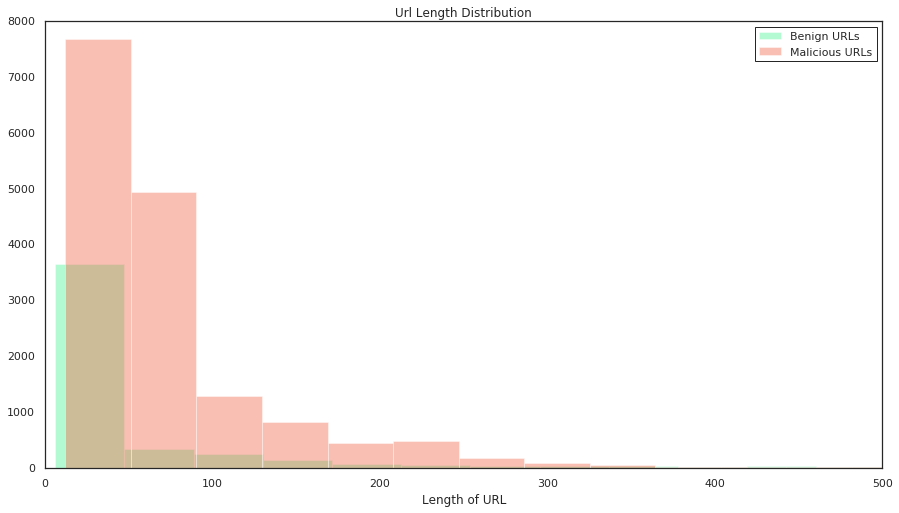

In [13]:
warnings.filterwarnings('ignore')
fig = plt.figure(figsize=(15,8))

sns.distplot(
    dataset[dataset['label']==0]['urllength'],
    color=green_color,
    label='Benign URLs',kde=False,
).set(xlim=(0, 500))
sns.distplot(
    dataset[dataset['label']==1]['urllength'],
    color=red_color,
    label='Malicious URLs',kde=False,
).set(xlim=(0, 500))
plt.title('Url Length Distribution')
plt.legend(loc='upper right')
plt.xlabel('Length of URL')

plt.show()

### Distribution of URLs based on number of parameters


Benign URLs description:
count    4847.000000
mean        1.934599
std         7.314726
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       115.000000
Name: parameters, dtype: float64

Malicious URLs description:
count    16028.000000
mean         0.598640
std          1.605177
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         23.000000
Name: parameters, dtype: float64


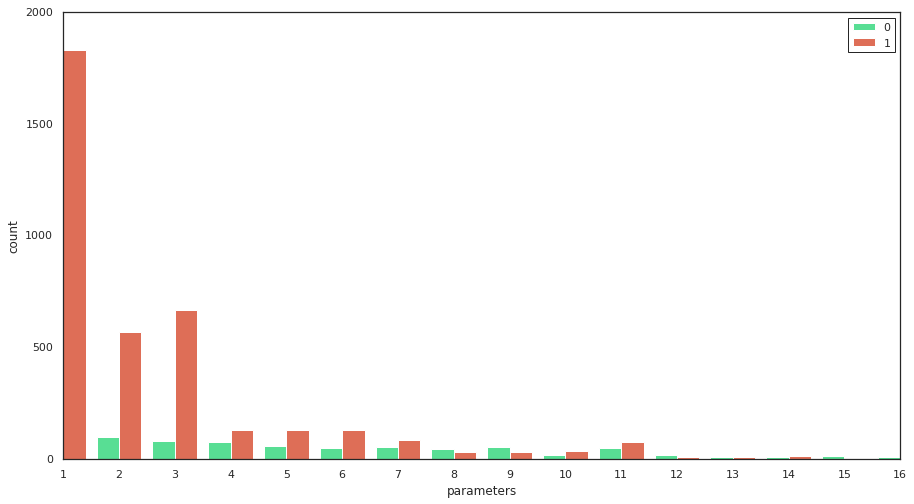

In [14]:
print ("\nBenign URLs description:")
print (dataset['parameters'][dataset.label == 0].describe())
print ("\nMalicious URLs description:")
print (dataset['parameters'][dataset.label == 1].describe())

count_plot(dataset[dataset["parameters"] > 0], "parameters",xlim=(0,15))

plt.legend(loc='upper right')

### Distribution of URLs based on number of dots in their domain


Benign URLs description:
count    4847.000000
mean        2.323086
std         3.309089
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        86.000000
Name: dots, dtype: float64

Malicious URLs description:
count    16028.000000
mean         2.396182
std          1.653489
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         29.000000
Name: dots, dtype: float64


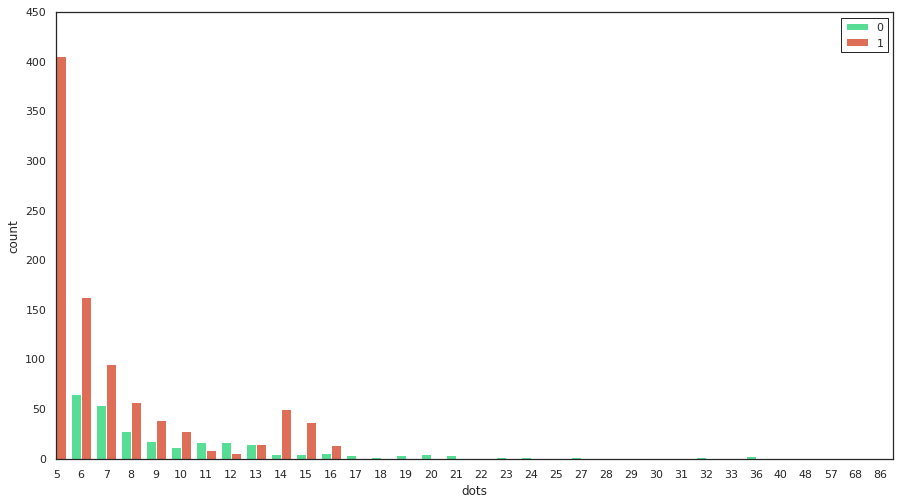

In [15]:
print ("\nBenign URLs description:")
print (dataset['dots'][dataset.label == 0].describe())
print ("\nMalicious URLs description:")
print (dataset['dots'][dataset.label == 1].describe())

count_plot(dataset[dataset['dots'] > 4], "dots",xlim=(0, None))

plt.legend(loc='upper right')

### Distribution of URLs based on number of dots in their subdomain


Benign URLs description:
count    4847.000000
mean        0.058180
std         0.292143
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         9.000000
Name: subdomaindots, dtype: float64

Malicious URLs description:
count    16028.000000
mean         0.065698
std          0.444304
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         12.000000
Name: subdomaindots, dtype: float64


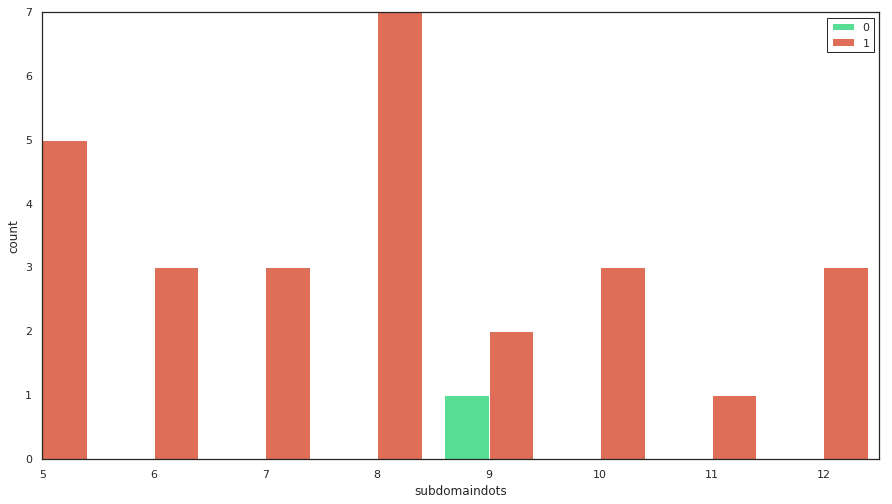

In [16]:
print ("\nBenign URLs description:")
print (dataset['subdomaindots'][dataset.label == 0].describe())
print ("\nMalicious URLs description:")
print (dataset['subdomaindots'][dataset.label == 1].describe())

count_plot(dataset[dataset['subdomaindots'] > 4], "subdomaindots",xlim=(0, None))

plt.legend(loc='upper right')


Benign URLs description:
count    4847.000000
mean        0.002888
std         0.064178
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: ats, dtype: float64

Malicious URLs description:
count    16028.000000
mean         0.056339
std          0.325889
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.000000
Name: ats, dtype: float64


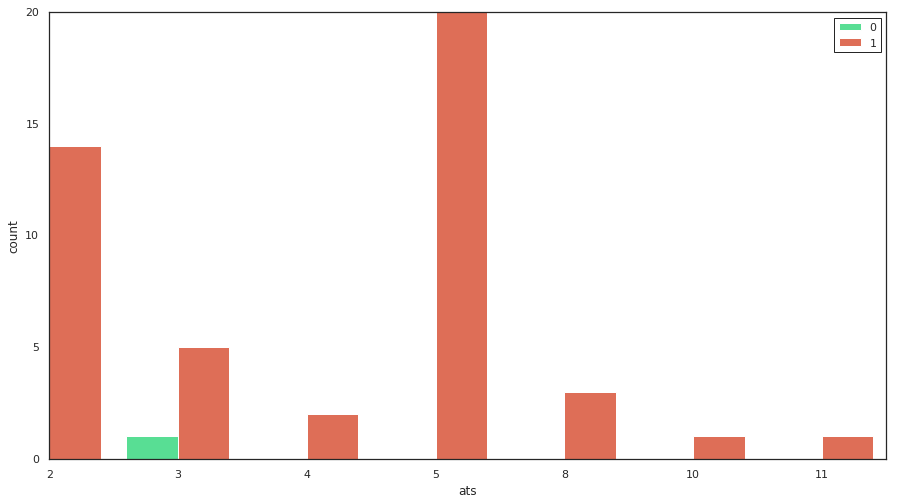

In [17]:
print ("\nBenign URLs description:")
print (dataset['ats'][dataset.label == 0].describe())
print ("\nMalicious URLs description:")
print (dataset['ats'][dataset.label == 1].describe())

count_plot(dataset[dataset['ats']>1], "ats",xlim=(0, None))

plt.legend(loc='upper right')

# Machine Learning Algorithms

In [18]:
import sklearn.ensemble as ek
from sklearn import model_selection, tree, linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.externals.six import StringIO
import pydot
import itertools

In [19]:
def fit_and_score(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [20]:
def cross_validate(model, X, y):
    return cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()

In [21]:
def plot_confusion_matrix (cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    if normalize: #print normalize confusion matrix
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Decision Tree Classification

In [22]:
X = dataset.drop(['url', 'label'], axis = 1).values
y = dataset['label'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

dtc = tree.DecisionTreeClassifier(max_depth = 10)

start = time.time()
print ("Decision Tree: {}".format(fit_and_score(dtc, X_train, y_train)))
print ("Cross validation result: {}".format(cross_validate(dtc, X, y)))
print ("Took {} s".format(time.time() - start))

Decision Tree: 0.9849101796407186
Cross validation result: 0.977294375911748
Took 0.27499961853027344 s


Recall metric in the testing dataset:  0.9937441351266812
Recall metric in the testing dataset:  0.9937441351266812
Recall metric in the testing dataset:  0.9937441351266812
Recall metric in the testing dataset:  0.9934313418830153
Recall metric in the testing dataset:  0.9934313418830153
Recall metric in the testing dataset:  0.9928057553956835
Recall metric in the testing dataset:  0.9921801689083516
Recall metric in the testing dataset:  0.9918673756646856
Recall metric in the testing dataset:  0.9896778229590241


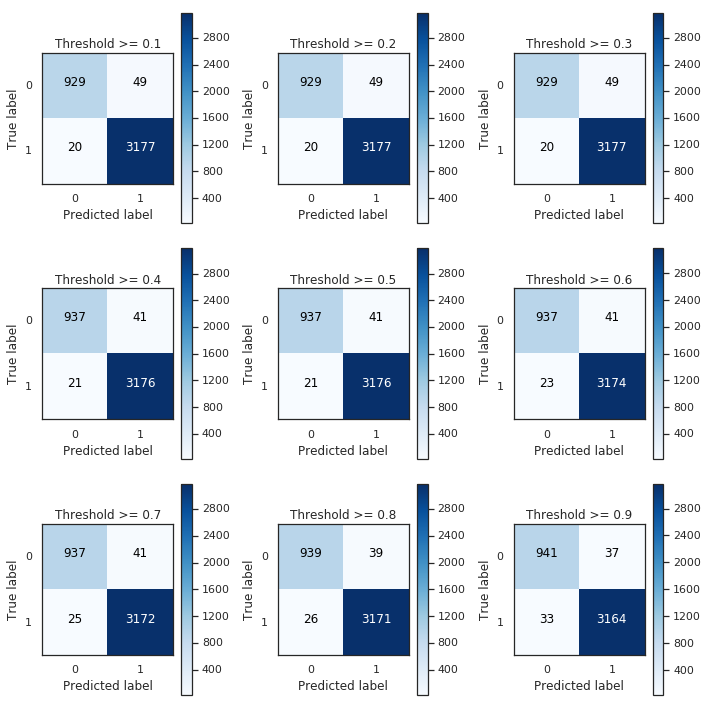

In [23]:
plt.figure(figsize=(10, 10))

import numpy as np 
np.set_printoptions(precision=2)
thresholds = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

# Probabilities that de URLs are malicious
probabilities = dtc.predict_proba(X_test) [:,1]
j = 1
for i in thresholds:
    predictions = np.where(probabilities >= i, 1, 0)
    
    plt.subplot(3, 3, j)
    j += 1
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    
    print("Recall metric in the testing dataset: ", conf_matrix[1, 1] / float(conf_matrix[1, 0] + conf_matrix[1, 1]))
    
    # Plot non-normalized confusion matrix
    class_names = [0, 1]
    plot_confusion_matrix(conf_matrix, classes = class_names, title = 'Threshold >= %s' %i)

In [24]:
from dtreeviz.trees import *
from IPython.display import Image, display_svg


viz = dtreeviz(dtc, 
               X_train,
               y_train,
               target_name='label',
               feature_names=dataset.drop(['url', 'label'], axis = 1).columns.values, 
               class_names=[0, 1]
              )
viz

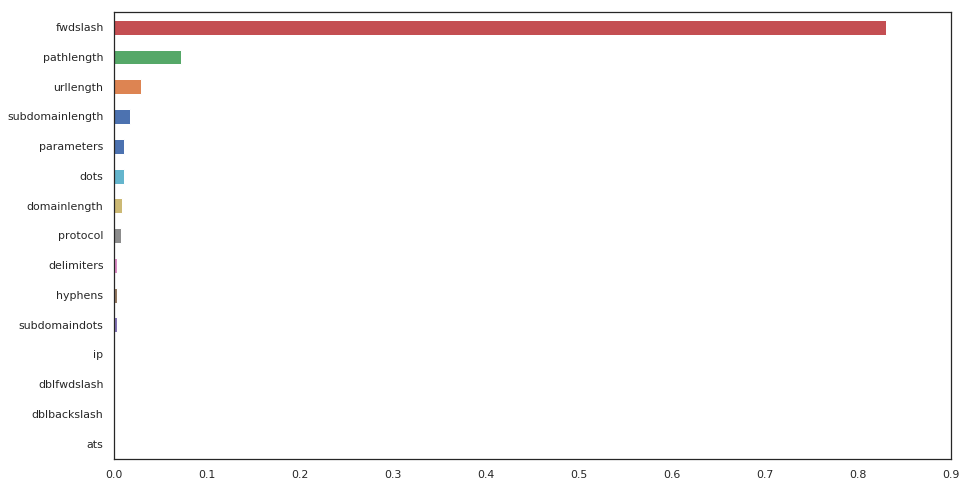

In [25]:
pd.Series(
    dtc.feature_importances_, 
    index=dataset.drop(['url', 'label'], axis = 1).columns
).sort_values().plot(kind="barh", figsize=(15,8))

In [26]:
# Keeping only top 4 features.
X_i = dataset[["fwdslash", "pathlength", "urllength", "subdomainlength"]].values
y_i = dataset['label'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_i, y_i, test_size = 0.2)

dtc_i = tree.DecisionTreeClassifier(max_depth = 100)

start = time.time()
print ("Decision Tree: {}".format(fit_and_score(dtc_i, X_train, y_train)))
print ("Cross validation result: {}".format(cross_validate(dtc_i, X_i, y_i)))
print ("Took {} s".format(time.time() - start))

Decision Tree: 0.9803592814371257
Cross validation result: 0.9739893537006639
Took 0.15007901191711426 s


In [27]:
# Keeping only the most important feature
X_ii = dataset[["fwdslash"]].values
y_ii = dataset['label'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_ii, y_ii, test_size = 0.2)

dtc_ii = tree.DecisionTreeClassifier(max_depth = 100)

start = time.time()
print ("Decision Tree: {}".format(fit_and_score(dtc_i, X_train, y_train)))
print ("Cross validation result: {}".format(cross_validate(dtc_ii, X_ii, y_ii)))
print ("Took {} s".format(time.time() - start))

Decision Tree: 0.9317365269461078
Cross validation result: 0.9279044062737283
Took 0.04008626937866211 s


### Logistic Regression

In [28]:
X = dataset.drop(['url', 'label'], axis = 1).values
y = dataset['label'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)
logreg = LogisticRegression()
start = time.time()
print ("Logistic regression: {}".format(fit_and_score(logreg, X_train, y_train)))
print ("Cross validation result: {}".format(cross_validate(logreg, X, y)))
print ("Took {} s".format(time.time() - start))

Logistic regression: 0.9707784431137725
Cross validation result: 0.9688635131578567
Took 2.601499080657959 s


Recall metric in the testing dataset:  0.9953632148377125
Recall metric in the testing dataset:  0.9910355486862442
Recall metric in the testing dataset:  0.9863987635239567
Recall metric in the testing dataset:  0.9842349304482225
Recall metric in the testing dataset:  0.9774343122102009
Recall metric in the testing dataset:  0.970015455950541
Recall metric in the testing dataset:  0.957032457496136
Recall metric in the testing dataset:  0.9264296754250386
Recall metric in the testing dataset:  0.8819165378670788


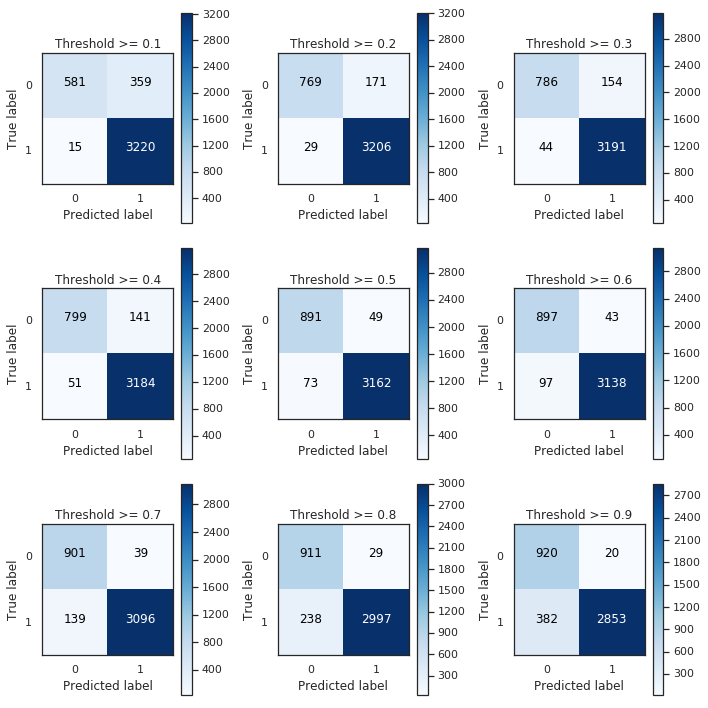

In [29]:
plt.figure(figsize=(10, 10))

import numpy as np 
np.set_printoptions(precision=2)
thresholds = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

# Probabilities that de URLs are malicious
probabilities = logreg.predict_proba(X_test) [:,1]
j = 1
for i in thresholds:
    predictions = np.where(probabilities >= i, 1, 0)
    
    plt.subplot(3, 3, j)
    j += 1
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    
    print("Recall metric in the testing dataset: ", conf_matrix[1, 1] / float(conf_matrix[1, 0] + conf_matrix[1, 1]))
    
    # Plot non-normalized confusion matrix
    class_names = [0, 1]
    plot_confusion_matrix(conf_matrix, classes = class_names, title = 'Threshold >= %s' %i)

In [30]:
X = dataset[["fwdslash", "pathlength", "urllength", "subdomainlength"]].values
y = dataset['label'].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

logreg = LogisticRegression()
start = time.time()
print ("Logistic regression: {}".format(fit_and_score(logreg, X_train, y_train)))
print ("Cross validation result: {}".format(cross_validate(logreg, X, y)))
print ("Took {} s".format(time.time() - start))

Logistic regression: 0.9494610778443113
Cross validation result: 0.9431391332135062
Took 2.4987850189208984 s


### Random Forest

In [31]:
X = dataset.drop(['url', 'label'], axis = 1).values
y = dataset['label'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

rf = ek.RandomForestClassifier(n_estimators = 100)

start = time.time()
print ("Random Forest: {}".format(fit_and_score(rf, X_train, y_train)))
print ("Cross validation result: {}".format(cross_validate(rf, X, y)))
print ("Took {} s".format(time.time() - start))

Random Forest: 0.9908982035928143
Cross validation result: 0.9879765865940628
Took 6.149944067001343 s


Recall metric in the testing dataset:  0.9996876951905059
Recall metric in the testing dataset:  0.9993753903810119
Recall metric in the testing dataset:  0.9990630855715178
Recall metric in the testing dataset:  0.9987507807620237
Recall metric in the testing dataset:  0.9978138663335415
Recall metric in the testing dataset:  0.9965646470955652
Recall metric in the testing dataset:  0.9934415990006246
Recall metric in the testing dataset:  0.9881324172392255
Recall metric in the testing dataset:  0.9725171767645222


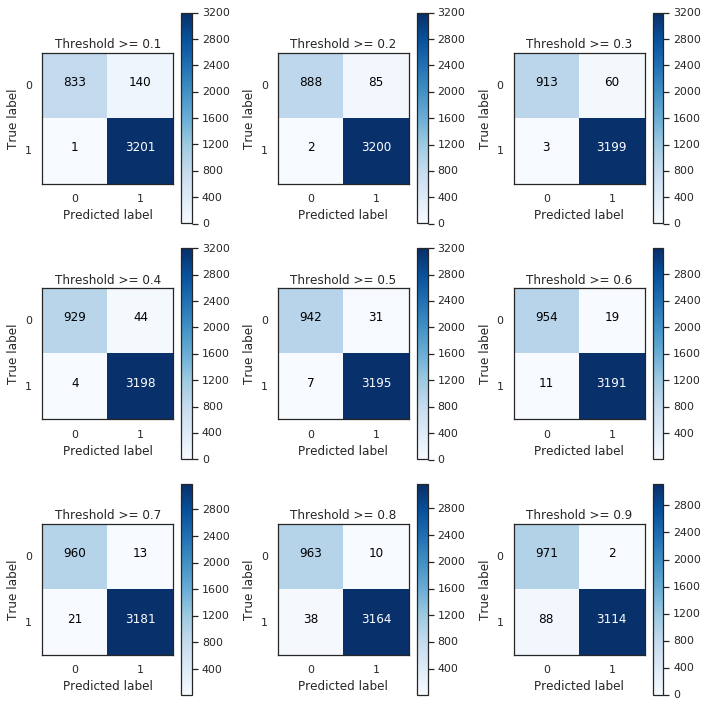

In [32]:
plt.figure(figsize=(10, 10))

import numpy as np 
np.set_printoptions(precision=2)
thresholds = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

# Probabilities that de URLs are malicious
probabilities = rf.predict_proba(X_test) [:,1]
j = 1
for i in thresholds:
    predictions = np.where(probabilities >= i, 1, 0)
    
    plt.subplot(3, 3, j)
    j += 1
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    
    print("Recall metric in the testing dataset: ", conf_matrix[1, 1] / float(conf_matrix[1, 0] + conf_matrix[1, 1]))
    
    # Plot non-normalized confusion matrix
    class_names = [0, 1]
    plot_confusion_matrix(conf_matrix, classes = class_names, title = 'Threshold >= %s' %i)

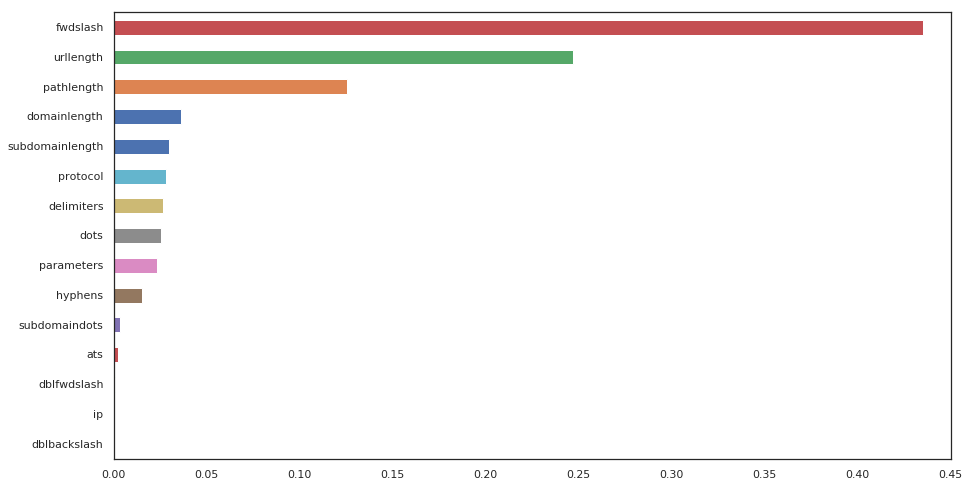

In [33]:
pd.Series(
    rf.feature_importances_, 
    index=dataset.drop(['url', 'label'], axis = 1).columns
).sort_values().plot(kind="barh", figsize=(15,8))

In [34]:
# Keeping only top 4 features
X_i = dataset[["fwdslash", 
               "urllength", 
               "pathlength", 
               "domainlength", 
              ]].values
y_i = dataset['label'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_i, y_i, test_size = 0.2)

rf_i = ek.RandomForestClassifier(n_estimators = 100)

start = time.time()
print ("Random Forest: {}".format(fit_and_score(rf_i, X_train, y_train)))
print ("Cross validation result: {}".format(cross_validate(rf, X_i, y_i)))
print ("Took {} s".format(time.time() - start))

Random Forest: 0.9829940119760479
Cross validation result: 0.9783966543283299
Took 7.026154518127441 s


In [35]:
# Lowering the number of estimators but keeping all the features
X = dataset.drop(['url', 'label'], axis = 1).values
y = dataset['label'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

rf = ek.RandomForestClassifier(n_estimators = 7)

start = time.time()
print ("Random Forest: {}".format(fit_and_score(rf, X_train, y_train)))
print ("Cross validation result: {}".format(cross_validate(rf, X, y)))
print ("Took {} s".format(time.time() - start))

Random Forest: 0.9897005988023952
Cross validation result: 0.9855812965986251
Took 0.6340649127960205 s


In [36]:
# Keeping only top 4 features and lowering the number of estimators
X_i = dataset[["fwdslash", 
               "urllength", 
               "pathlength", 
               "domainlength", 
              ]].values
y_i = dataset['label'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_i, y_i, test_size = 0.2)

rf_i = ek.RandomForestClassifier(n_estimators = 4)

start = time.time()
print ("Random Forest: {}".format(fit_and_score(rf_i, X_train, y_train)))
print ("Cross validation result: {}".format(cross_validate(rf, X_i, y_i)))
print ("Took {} s".format(time.time() - start))

Random Forest: 0.9822754491017964
Cross validation result: 0.9761930613765447
Took 0.579052209854126 s


### KNeighbors

In [37]:
from sklearn.neighbors import KNeighborsClassifier

X = dataset.drop(['url', 'label'], axis = 1).values
y = dataset['label'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

knn = KNeighborsClassifier(n_neighbors=3)

start = time.time()
print ("KNN: {}".format(fit_and_score(knn, X_train, y_train)))
print ("Cross validation result: {}".format(cross_validate(knn, X, y)))
print ("Took {} s".format(time.time() - start))

KNN: 0.978682634730539
Cross validation result: 0.9704918771140918
Took 1.0844073295593262 s


Recall metric in the testing dataset:  0.9953212726138491
Recall metric in the testing dataset:  0.9953212726138491
Recall metric in the testing dataset:  0.9953212726138491
Recall metric in the testing dataset:  0.9903306300686213
Recall metric in the testing dataset:  0.9903306300686213
Recall metric in the testing dataset:  0.9903306300686213
Recall metric in the testing dataset:  0.972239550842171
Recall metric in the testing dataset:  0.972239550842171
Recall metric in the testing dataset:  0.972239550842171


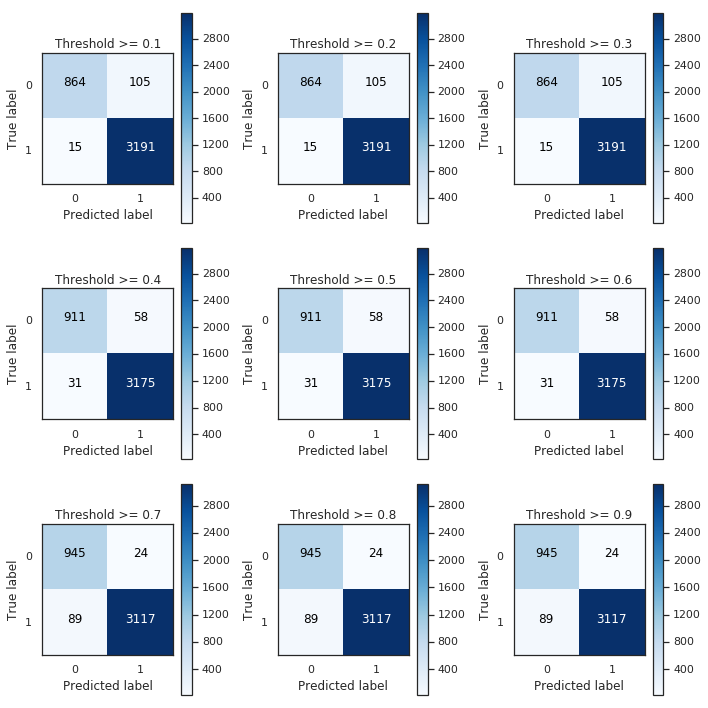

In [38]:
plt.figure(figsize=(10, 10))

import numpy as np 
np.set_printoptions(precision=2)
thresholds = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

# Probabilities that de URLs are malicious
probabilities = knn.predict_proba(X_test) [:,1]
j = 1
for i in thresholds:
    predictions = np.where(probabilities >= i, 1, 0)
    
    plt.subplot(3, 3, j)
    j += 1
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    
    print("Recall metric in the testing dataset: ", conf_matrix[1, 1] / float(conf_matrix[1, 0] + conf_matrix[1, 1]))
    
    # Plot non-normalized confusion matrix
    class_names = [0, 1]
    plot_confusion_matrix(conf_matrix, classes = class_names, title = 'Threshold >= %s' %i)

In [39]:
from sklearn.neighbors import KNeighborsClassifier

X_i = dataset[["fwdslash", 
               "urllength", 
               "pathlength", 
               "domainlength", 
              ]].values
y_i= dataset['label'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_i, y_i, test_size = 0.2)

knn = KNeighborsClassifier(n_neighbors=100)

start = time.time()
print ("KNN: {}".format(fit_and_score(knn, X_train, y_train)))
print ("Cross validation result: {}".format(cross_validate(knn, X_i, y_i)))
print ("Took {} s".format(time.time() - start))

KNN: 0.9544910179640719
Cross validation result: 0.9565999821977578
Took 1.201225996017456 s


In [40]:
# Trying to find the best k
from sklearn.neighbors import KNeighborsClassifier

X = dataset.drop(['url', 'label'], axis = 1).values
y = dataset['label'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

best_cross_val = 0
best_k = 0
results = {
    "k": [],
    "score": []
}

for k in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=k)
    cvscore = cross_val_score(knn, X, y, cv=5, scoring='accuracy').mean()
    results["k"].append(k)
    results["score"].append(cvscore)
    if cvscore > best_cross_val:
        best_cross_val = cvscore
        best_k = k

print("Best k: " + str(best_k))
print("Best score: " + str(best_cross_val))

Best k: 1
Best score: 0.9716416007379631


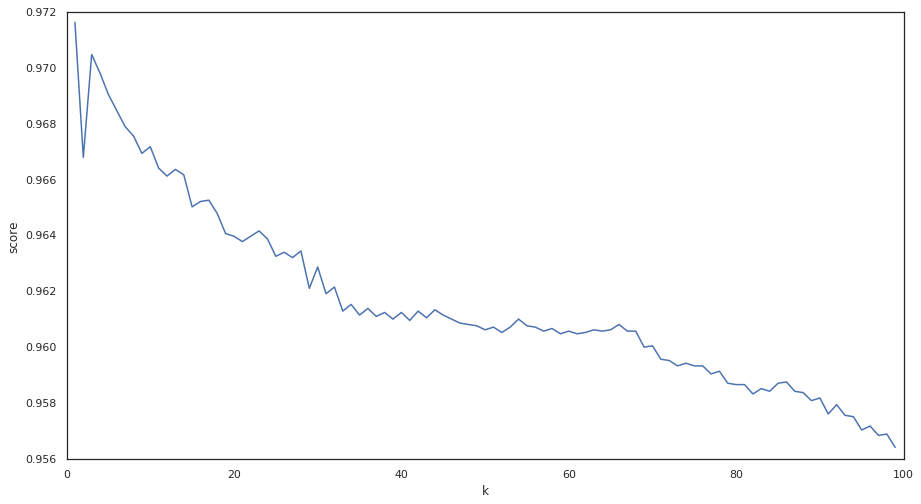

In [41]:
fig = plt.figure(figsize=(15,8))
knn_df = pd.DataFrame(data=results)
sns.lineplot(data=knn_df, x="k", y="score")